<a href="https://colab.research.google.com/github/roger-tseng/self-supervised-vq-segmentation/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Phoneme Segmentation with HuBERT representations

This notebook demonstrates how to use and visualize the dynamic-programing-based phoneme segmentation method described in [this INTERSPEECH 2021 paper](https://arxiv.org/abs/2012.07551):


This notebook is meant to be run on Google Colab, and will take about 15 minutes to complete.

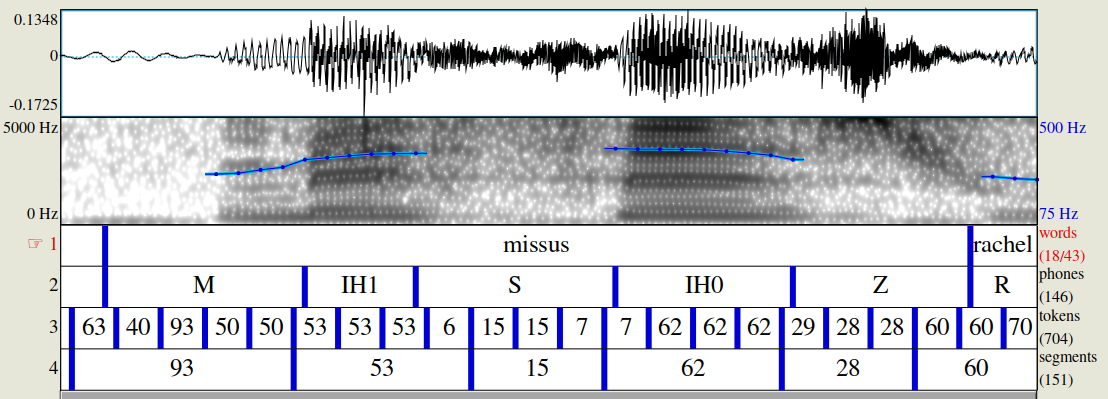

In [1]:
!git clone https://github.com/roger-tseng/self-supervised-vq-segmentation self_supervised_vq_segmentation

Cloning into 'self_supervised_vq_segmentation'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 18 (delta 3), reused 16 (delta 3), pack-reused 0
Unpacking objects: 100% (18/18), done.


# **Installing the S3PRL toolkit requires a runtime restart,** 
# **so please use `Run after` after installing S3PRL**

## Install S3PRL (about 5 mins)
Runtime will restart to use newly installed toolkit versions

In [2]:
!apt-get install libsox-fmt-all libsox-dev sox
!git clone https://github.com/s3prl/s3prl
%cd s3prl
!pip install -e ./
!pip install fairseq@git+https://github.com//pytorch/fairseq.git@f2146bdc7abf293186de9449bfa2272775e39e1d#egg=fairseq
%cd ..
# Exit current runtime to force restart
exit()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libmagic-mgc libmagic1
  libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa libsox-fmt-ao
  libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse libsox3
Suggested packages:
  libaudio2 file
The following NEW packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libmagic-mgc libmagic1
  libopencore-amrnb0 libopencore-amrwb0 libsox-dev libsox-fmt-all
  libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3 libsox-fmt-oss
  libsox-fmt-pulse libsox3 sox
0 upgraded, 18 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,267 kB of archives.
After this operation, 9,153 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/u

  Cloning https://github.com//pytorch/fairseq.git (to revision f2146bdc7abf293186de9449bfa2272775e39e1d) to /tmp/pip-install-3xvo76rv/fairseq_dffdd18bb35e46f8a7d3e8e3e32f0cb2
  Running command git clone -q https://github.com//pytorch/fairseq.git /tmp/pip-install-3xvo76rv/fairseq_dffdd18bb35e46f8a7d3e8e3e32f0cb2
  Running command git rev-parse -q --verify 'sha^f2146bdc7abf293186de9449bfa2272775e39e1d'
  Running command git fetch -q https://github.com//pytorch/fairseq.git f2146bdc7abf293186de9449bfa2272775e39e1d
  Running command git checkout -q f2146bdc7abf293186de9449bfa2272775e39e1d
  Running command git submodule update --init --recursive -q
  From https://github.com/ngoyal2707/Megatron-LM
   * branch            adb23324c222aad0aad89308e70302d996a5eaeb -> FETCH_HEAD
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 123 kB 30.1 

### Download k-means model 
See [FAIRSEQ GSLM](https://github.com/pytorch/fairseq/tree/main/examples/textless_nlp/gslm/speech2unit) repo for more details

In [1]:
%cd self_supervised_vq_segmentation
!wget -q --show-progress https://dl.fbaipublicfiles.com/textless_nlp/gslm/hubert/km100/km.bin

/content/self_supervised_vq_segmentation
km.bin              100%[===================>] 301.24K   941KB/s    in 0.3s    


## Install Montreal Forced Aligner (MFA) (about 6 mins)

In [2]:
%%writefile install_mfa.sh
#!/bin/bash

## a script to install Montreal Forced Aligner (MFA)

root_dir=${1:-/tmp/mfa}
mkdir -p $root_dir
cd $root_dir

# download miniconda3
wget -q --show-progress https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh -b -p $root_dir/miniconda3 -f

#install MFA
$root_dir/miniconda3/bin/conda create -n aligner -c conda-forge montreal-forced-aligner -y

echo -e "\n======== DONE =========="
echo -e "\nTo activate MFA, run: source $root_dir/miniconda3/bin/activate aligner"
echo -e "\nTo delete MFA, run: rm -rf $root_dir"
echo -e "\nSee: https://montreal-forced-aligner.readthedocs.io/en/latest/aligning.html to know how to use MFA"

Writing install_mfa.sh


In [3]:
# download and install mfa
INSTALL_DIR="/tmp/mfa" # path to install directory

!bash ./install_mfa.sh {INSTALL_DIR}
!source {INSTALL_DIR}/miniconda3/bin/activate aligner; mfa align --help

Miniconda3-latest-L 100%[===================>]  72.16M   222MB/s    in 0.3s    
PREFIX=/tmp/mfa/miniconda3
Unpacking payload ...
Solving environment: / - \ done

## Package Plan ##

  environment location: /tmp/mfa/miniconda3

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py39h27cfd23_1003
    - ca-certificates==2021.10.26=h06a4308_2
    - certifi==2021.10.8=py39h06a4308_2
    - cffi==1.15.0=py39hd667e15_1
    - charset-normalizer==2.0.4=pyhd3eb1b0_0
    - conda-content-trust==0.1.1=pyhd3eb1b0_0
    - conda-package-handling==1.7.3=py39h27cfd23_1
    - conda==4.11.0=py39h06a4308_0
    - cryptography==36.0.0=py39h9ce1e76_0
    - idna==3.3=pyhd3eb1b0_0
    - ld_impl_linux-64==2.35.1=h7274673_9
    - libffi==3.3=he6710b0_2
    - libgcc-ng==9.3.0=h5101ec6_17
    - libgomp==9.3.0=h5101ec6_17
    - libstdcxx-ng==9.3.0=hd4cf53a_17
    - ncurses==6.3=h7f8727e_2
    - openssl==1.1.1m=h7f8727e_0
    - pip==21.2.4=py39h06a4308_0
 

### Download lexicon and acoustic model

In [4]:
# download a pretrained english acoustic model, and english lexicon
!wget -q --show-progress https://github.com/MontrealCorpusTools/mfa-models/raw/main/acoustic/english.zip
!wget -q --show-progress http://www.openslr.org/resources/11/librispeech-lexicon.txt

english.zip         100%[===================>]  14.05M  --.-KB/s    in 0.05s   
librispeech-lexicon 100%[===================>]   5.37M  7.34MB/s    in 0.7s    


## Get word and phone boundaries

In [5]:
# align phonemes/words and speech
!source {INSTALL_DIR}/miniconda3/bin/activate aligner; \
mfa align -t ./temp -j 4 ./wav librispeech-lexicon.txt ./english.zip ./out
# output files are at ./out
!echo "See output files at ./out"

KW {'feature_type': 'mfcc', 'use_energy': False, 'frame_shift': 10, 'snip_edges': True, 'low_frequency': 20, 'high_frequency': 7800, 'sample_frequency': 16000, 'allow_downsample': True, 'allow_upsample': True, 'pitch': False, 'uses_cmvn': True, 'uses_deltas': True, 'uses_splices': False, 'uses_voiced': False, 'uses_speaker_adaptation': False, 'silence_weight': 0.0, 'fmllr_update_type': 'full', 'splice_left_context': 3, 'splice_right_context': 3, 'non_silence_phones': {'CH', 'V', 'IY1', 'AA0', 'AH0', 'UW2', 'OW2', 'OY0', 'AY0', 'D', 'HH', 'EH1', 'S', 'M', 'OW0', 'EH2', 'AO1', 'IY2', 'UW0', 'AY1', 'F', 'ZH', 'AW2', 'R', 'EH0', 'AE0', 'B', 'ER0', 'AW0', 'Z', 'UH0', 'Y', 'AA1', 'OY2', 'ER2', 'UH1', 'IY0', 'AE1', 'OW1', 'JH', 'T', 'UW1', 'W', 'L', 'OY1', 'IH0', 'SH', 'IH1', 'AA2', 'DH', 'IH2', 'UH2', 'N', 'AH2', 'AW1', 'K', 'EY0', 'TH', 'AO0', 'AY2', 'EY1', 'AE2', 'ER1', 'EY2', 'P', 'AH1', 'AO2', 'G', 'NG'}, 'oov_phone': 'spn', 'optional_silence_phone': 'sil', 'phone_set_type': 'UNKNOWN', '

## Get HuBERT representations with S3PRL

In [6]:
import s3prl.hub as hub
import torch
import soundfile as sf
import joblib
from self_supervised_vq_segmentation import segment

# Read input audio
utterance = sf.read('./wav/103-1240-0000.flac')[0]
utterance = torch.from_numpy(utterance).to(torch.float)

# Obtain HuBERT 6th layer representations of input
model = getattr(hub, 'hubert')()
model.eval()
reps = model([utterance])['hidden_state_6'].squeeze()
reps = reps.detach().numpy()

# Perform k-means clustering with pretrained scikit-learn k-means model at https://github.com/pytorch/fairseq/tree/main/examples/textless_nlp/gslm/speech2unit
K = 100 # num of k-means clusters
kmeans_model = joblib.load('./km.bin')

# Predict vector quantized tokens
tokens = kmeans_model.predict(reps).tolist()
print(f"tokens: {tokens}")
print(f"len(tokens): {len(tokens)}")

boundary_tokens, label_tokens = segment.segment(reps, kmeans_model, segment.pen, 35)
print(f"boundaries: {boundary_tokens}")
print(f"label_tokens: {label_tokens}")
print(f"Num of segments = {len(label_tokens)}")

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



[s3prl.downstream.experts] Warning: can not import s3prl.downstream.a2a-vc-vctk.expert: No module named 'resemblyzer'. Pass.
Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

tokens: [71, 71, 71, 71, 12, 12, 12, 12, 12, 12, 63, 12, 12, 12, 12, 12, 12, 57, 57, 40, 40, 40, 40, 21, 21, 95, 59, 87, 91, 91, 43, 43, 74, 2, 2, 31, 5, 5, 30, 30, 70, 70, 14, 14, 24, 68, 68, 68, 68, 42, 44, 80, 81, 81, 81, 10, 83, 83, 83, 10, 10, 10, 10, 10, 83, 63, 54, 56, 40, 57, 40, 40, 93, 93, 93, 50, 50, 53, 53, 62, 6, 15, 7, 7, 62, 62, 29, 29, 28, 28, 60, 60, 52, 52, 25, 94, 32, 32, 74, 74, 21, 95, 95, 23, 23, 19, 19, 19, 90, 90, 90, 35, 35, 87, 38, 38, 38, 44, 80, 80, 18, 18, 31, 31, 10, 37, 37, 27, 37, 53, 53, 53, 29, 6, 15, 15, 15, 7, 23, 73, 74, 27, 47, 52, 52, 52, 24, 13, 13, 13, 13, 58, 58, 58, 58, 42, 29, 29, 15, 15, 49, 92, 92, 31, 41, 83, 8

### Install .TextGrid manipulation library (comes with MFA)

In [7]:
!pip install praatio

     |████████████████████████████████| 77 kB 4.5 MB/s 


### Add original HuBERT discrete unit sequence to .TextGrid file

In [8]:
from praatio import textgrid
from praatio.utilities.constants import Interval

test = textgrid.openTextgrid('./out/103-1240-0000.TextGrid', includeEmptyIntervals=True)
start = test.minTimestamp
end = test.maxTimestamp
sample_freq = 16000
down_rate = 320

# tokens = [14, 14, 14, 14, 131, 131, 131, 131, 131, 132, 117, 132, 132, 132, 132, 132, 132, 117, 117, 22, 22, 22, 22, 195, 195, 171, 98, 46, 148, 148, 148, 79, 71, 71, 30, 44, 127, 165, 165, 54, 21, 130, 128, 128, 128, 5, 5, 5, 26, 147, 82, 75, 75, 75, 139, 68, 84, 84, 84, 84, 84, 84, 84, 84, 84, 117, 8, 8, 8, 117, 22, 22, 10, 10, 10, 177, 106, 106, 187, 151, 111, 180, 15, 41, 151, 151, 126, 87, 157, 48, 48, 183, 183, 3, 81, 49, 159, 159, 12, 71, 195, 171, 98, 98, 45, 45, 45, 9, 169, 169, 134, 58, 58, 193, 119, 25, 25, 82, 63, 63, 93, 93, 66, 129, 0, 0, 133, 89, 57, 113, 113, 151, 126, 111, 180, 180, 15, 15, 41, 115, 85, 85, 154, 154, 150, 81, 81, 97, 97, 97, 97, 108, 108, 108, 184, 184, 192, 192, 180, 39, 39, 62, 62, 129, 68, 84, 84, 188, 188, 188, 188, 188, 188, 188, 188, 188, 77, 77, 188, 77, 77, 117, 188, 188, 188, 117, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 188, 107, 188, 107, 117, 107, 107, 107, 117, 90, 107, 117, 107, 107, 107, 107, 107, 107, 117, 107, 107, 117, 107, 117, 107, 107, 55, 117, 107, 107, 117, 55, 117, 55, 55, 2, 2, 2, 2, 2, 2, 2, 2, 138, 138, 138, 42, 42, 42, 11, 11, 22, 117, 22, 10, 10, 106, 106, 187, 187, 111, 180, 180, 15, 41, 151, 151, 126, 87, 19, 19, 48, 48, 183, 183, 3, 49, 49, 159, 12, 71, 71, 171, 171, 98, 16, 45, 45, 9, 9, 134, 134, 134, 58, 58, 187, 187, 187, 1, 25, 82, 75, 75, 75, 75, 93, 93, 129, 68, 68, 84, 84, 133, 133, 117, 22, 10, 134, 134, 58, 58, 187, 187, 187, 143, 143, 104, 30, 133, 133, 133, 133, 133, 117, 195, 195, 171, 98, 16, 5, 5, 5, 78, 111, 180, 180, 120, 62, 62, 129, 48, 21, 130, 128, 116, 116, 38, 38, 24, 6, 121, 59, 144, 144, 28, 0, 0, 57, 174, 148, 148, 148, 148, 148, 79, 79, 104, 136, 136, 51, 51, 63, 63, 134, 134, 58, 58, 194, 194, 198, 198, 198, 198, 12, 53, 177, 177, 177, 177, 177, 106, 106, 49, 49, 49, 50, 50, 50, 50, 82, 114, 182, 182, 182, 183, 183, 183, 183, 3, 81, 81, 186, 186, 186, 186, 164, 164, 65, 65, 185, 129, 68, 68, 84, 197, 133, 8, 22, 22, 22, 22, 22, 22, 44, 44, 113, 187, 187, 95, 71, 71, 30, 133, 133, 133, 133, 133, 133, 133, 22, 22, 89, 44, 44, 193, 88, 88, 88, 88, 88, 155, 155, 155, 147, 114, 7, 119, 51, 93, 66, 66, 31, 100, 100, 173, 173, 173, 54, 54, 54, 134, 134, 58, 136, 187, 187, 69, 127, 127, 45, 45, 9, 9, 23, 142, 142, 142, 142, 199, 199, 83, 83, 83, 169, 169, 169, 136, 136, 186, 186, 186, 164, 124, 124, 36, 162, 162, 166, 166, 161, 161, 161, 161, 161, 161, 161, 42, 11, 11, 117, 122, 122, 103, 4, 4, 4, 4, 3, 3, 187, 187, 82, 63, 63, 93, 93, 171, 171, 171, 62, 44, 48, 21, 116, 116, 6, 6, 59, 0, 0, 174, 174, 199, 199, 199, 33, 33, 9, 9, 71, 89, 127, 165, 165, 165, 24, 24, 192, 87, 157, 157, 41, 119, 119, 51, 63, 63, 134, 134, 134, 134, 58, 49, 49, 49, 159, 159, 12, 69, 127, 198, 198, 198, 12, 192, 87, 180, 157, 48, 175, 28, 28, 165, 38, 24, 172, 85, 195, 150, 150, 81, 81, 83, 83, 83, 79, 79, 71, 30, 30, 180, 180, 15, 41, 119, 51, 82, 93, 93, 66, 150, 150, 109, 109, 54, 13, 104, 104, 76, 76, 76, 76, 76, 24, 40, 19, 19, 62, 62, 129, 48, 74, 74, 73, 145, 145, 108, 108, 184, 184, 184, 115, 13, 13, 156, 156, 156, 73, 3, 3, 3, 81, 26, 26, 26, 95, 95, 71, 34, 34, 68, 36, 36, 162, 137, 137, 92, 92]

# No segmentation:
boundaries = [(start+80+(i+1)*down_rate)/sample_freq for i in range(len(tokens))] # right boundary of each token
phoneme_tokens = tokens

token_intervals = [Interval(start, boundaries[0], str(phoneme_tokens[0]))]
for i in range(len(boundaries)-1):
    start_time = boundaries[i]
    end_time = boundaries[i+1]
    token_intervals.append(Interval(start_time, end_time, str(phoneme_tokens[i+1])))

token_tier = textgrid.IntervalTier('tokens', token_intervals, start, end)
test.addTier(token_tier)

In [9]:
#boundary_tokens = [10, 23, 26, 28, 31, 35, 37, 40, 44, 49, 53, 59, 68, 75, 78, 80, 83, 87, 91, 95, 98, 100, 103, 105, 112, 114, 118, 122, 125, 131, 133, 137, 139, 141, 143, 146, 153, 157, 159, 162, 165, 179, 200, 201, 204, 205, 207, 208, 214, 215, 219, 220, 230, 245, 251, 254, 257, 260, 264, 268, 271, 273, 276, 278, 280, 283, 290, 292, 302, 306, 314, 318, 320, 323, 331, 335, 339, 341, 344, 348, 351, 354, 357, 361, 365, 371, 374, 377, 382, 390, 397, 403, 406, 411, 415, 419, 425, 427, 431, 440, 444, 449, 458, 463, 469, 472, 474, 476, 479, 484, 486, 489, 493, 495, 500, 506, 510, 513, 518, 520, 523, 532, 535, 538, 543, 545, 548, 553, 556, 558, 561, 564, 569, 573, 576, 579, 582, 585, 587, 591, 595, 599, 603, 606, 610, 613, 618, 621, 623, 625, 628, 631, 633, 637, 640, 643, 645, 647, 651, 654, 659, 662, 664, 668, 670, 674, 678, 681, 685, 689, 693, 697, 699, 704]
boundaries = [(start+80+i*down_rate)/sample_freq for i in boundary_tokens]
#phoneme_tokens = [131, 132, 195, 98, 148, 71, 44, 101, 130, 5, 26, 139, 191, 22, 106, 187, 180, 151, 157, 3, 159, 95, 171, 16, 169, 193, 25, 63, 129, 57, 151, 180, 41, 115, 85, 150, 97, 184, 192, 39, 129, 197, 64, 117, 107, 117, 188, 117, 107, 117, 107, 117, 64, 2, 22, 106, 187, 180, 151, 157, 183, 3, 159, 71, 171, 16, 169, 136, 1, 129, 133, 58, 187, 143, 133, 98, 5, 111, 120, 48, 128, 38, 6, 144, 0, 148, 104, 54, 134, 194, 177, 49, 50, 182, 183, 16, 164, 185, 84, 22, 113, 71, 133, 193, 155, 114, 119, 93, 31, 173, 54, 134, 187, 127, 54, 142, 199, 169, 26, 124, 36, 166, 42, 22, 4, 3, 113, 93, 171, 44, 116, 6, 174, 199, 9, 136, 165, 192, 157, 119, 182, 105, 159, 69, 198, 87, 144, 165, 13, 195, 81, 83, 79, 30, 15, 51, 93, 195, 109, 104, 76, 40, 19, 48, 73, 145, 184, 13, 73, 81, 26, 34, 36, 137]
phoneme_tokens = label_tokens
assert len(boundary_tokens)==len(phoneme_tokens)

token_intervals = [Interval(start, boundaries[0], str(phoneme_tokens[0]))]
for i in range(len(boundaries)-1):
    start_time = boundaries[i]
    end_time = boundaries[i+1]
    token_intervals.append(Interval(start_time, end_time, str(phoneme_tokens[i+1])))
#token_intervals[-1].end_time = end

seg_tier = textgrid.IntervalTier('segments', token_intervals, start, end)
test.addTier(seg_tier)

test.save('/content/103-1240-0000.TextGrid', "long_textgrid", includeBlankSpaces=True)

# Download and View Results with Praat
The resulting .TextGrid file can be viewed using the [Praat](https://www.fon.hum.uva.nl/praat/) software

# References
1. [LJSpeech Tutorial](https://gist.github.com/NTT123/12264d15afad861cb897f7a20a01762e) by NTT123